## Pipeline 3 — PCA → Transformer temporal 

In [20]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.metrics import (
    f1_score, balanced_accuracy_score, matthews_corrcoef,
    classification_report, confusion_matrix, average_precision_score,
    precision_recall_curve
)

import matplotlib.pyplot as plt

In [21]:
df = pd.read_parquet("../Limpieza_Completada/cicids2017_CleanBinary.parquet")
ts_df = pd.read_parquet("../Timestamp_Datetime_Terminado/Timestamp_Tipo_Datetime.parquet")
print("df:", df.shape, "| ts_df:", ts_df.shape)

df["Timestamp"] = ts_df["Timestamp"].values

df = df.sort_values("Timestamp").reset_index(drop=True)


df: (2830539, 73) | ts_df: (2830539, 1)


In [22]:
y = df["Attack"].astype(np.int64).values

X_df = df.select_dtypes(include=[np.number]).copy()
X_df = X_df.drop(columns=["Attack"]) 



In [23]:
n = len(df)
i_train = int(n * 0.70)
i_val   = int(n * 0.85)

X_train_df = X_df.iloc[:i_train]
X_val_df   = X_df.iloc[i_train:i_val]
X_test_df  = X_df.iloc[i_val:]

y_train = y[:i_train]
y_val   = y[i_train:i_val]
y_test  = y[i_val:]

print(X_train_df.shape, X_val_df.shape, X_test_df.shape)
print("train:", np.bincount(y_train))
print("val  :", np.bincount(y_val))
print("test :", np.bincount(y_test))

(1981377, 71) (424581, 71) (424581, 71)
train: [1714580  266797]
val  : [264157 160424]
test : [294157 130424]


In [24]:
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train_df)
X_val_sc   = scaler.transform(X_val_df)
X_test_sc  = scaler.transform(X_test_df)

pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train_sc)
X_val_pca   = pca.transform(X_val_sc)
X_test_pca  = pca.transform(X_test_sc)

print("PCA dims:", X_train_pca.shape, X_val_pca.shape, X_test_pca.shape)
print("n_components:", X_train_pca.shape[1])
print("NaNs PCA:", np.isnan(X_train_pca).sum(), np.isnan(X_val_pca).sum(), np.isnan(X_test_pca).sum())

PCA dims: (1981377, 26) (424581, 26) (424581, 26)
n_components: 26
NaNs PCA: 0 0 0


In [ ]:
WINDOW_SIZE = 20
STRIDE = 5

def make_window_indices(n, window_size, stride):
    return list(range(0, n - window_size + 1, stride))

class SeqWindowBinaryDataset(Dataset):
    def __init__(self, X_pca, y_bin, window_size, stride):
        self.X = torch.tensor(X_pca, dtype=torch.float32)
        self.y = np.asarray(y_bin, dtype=np.int64)
        self.ws = window_size
        self.starts = make_window_indices(len(self.y), window_size, stride)

    def __len__(self):
        return len(self.starts)

    def __getitem__(self, k):
        i = self.starts[k]
        x_win = self.X[i:i+self.ws]              # (T, D)
        y_win = int(self.y[i+self.ws-1])         # etiqueta del último flujo
        return x_win, y_win

train_ds = SeqWindowBinaryDataset(X_train_pca, y_train, WINDOW_SIZE, STRIDE)
val_ds   = SeqWindowBinaryDataset(X_val_pca,   y_val,   WINDOW_SIZE, STRIDE)
test_ds  = SeqWindowBinaryDataset(X_test_pca,  y_test,  WINDOW_SIZE, STRIDE)

print("windows:", len(train_ds), len(val_ds), len(test_ds))

windows: 396272 84913 84913


In [ ]:
def window_labels_last(y_flow, window_size, stride):
    y_flow = np.asarray(y_flow, dtype=np.int64)
    idxs = list(range(0, len(y_flow) - window_size + 1, stride))
    return np.array([y_flow[i + window_size - 1] for i in idxs], dtype=np.int64)

y_train_w = window_labels_last(y_train, WINDOW_SIZE, STRIDE)
print("train window labels bincount:", np.bincount(y_train_w))

class_counts = np.bincount(y_train_w, minlength=2)
class_weights = 1.0 / np.maximum(class_counts, 1)

sample_weights = class_weights[y_train_w]

sampler = WeightedRandomSampler(
    weights=torch.tensor(sample_weights, dtype=torch.double),
    num_samples=len(sample_weights),
    replacement=True
)

BATCH_SIZE = 256 

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, sampler=sampler, drop_last=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

print("batches:", len(train_loader), len(val_loader), len(test_loader))

train window labels bincount: [342971  53301]
batches: 1547 332 332


In [ ]:
device = torch.device("cpu")

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=512):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
        div = torch.exp(torch.arange(0, d_model, 2, dtype=torch.float32) * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(pos * div)
        pe[:, 1::2] = torch.cos(pos * div)
        self.register_buffer("pe", pe.unsqueeze(0))  # (1, max_len, d_model)

    def forward(self, x):
        T = x.size(1)
        return x + self.pe[:, :T, :]

class TinyTransformerBinary(nn.Module):
    def __init__(self, in_dim, d_model=64, nhead=4, num_layers=2, dim_ff=128, dropout=0.1):
        super().__init__()
        self.proj = nn.Linear(in_dim, d_model)
        self.pos = PositionalEncoding(d_model, max_len=512)

        enc_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead,
            dim_feedforward=dim_ff,
            dropout=dropout,
            batch_first=True,
            activation="gelu"
        )
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers=num_layers)

        self.head = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Linear(d_model, 1)  
        )

    def forward(self, x):
        h = self.proj(x)
        h = self.pos(h)
        h = self.encoder(h)          # (B, T, d_model)
        last = h[:, -1, :]           # último paso
        logit = self.head(last).squeeze(1)  # (B,)
        return logit

model = TinyTransformerBinary(in_dim=X_train_pca.shape[1]).to(device)
print(model)

TinyTransformerBinary(
  (proj): Linear(in_features=26, out_features=64, bias=True)
  (pos): PositionalEncoding()
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=128, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=128, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (head): Sequential(
    (0): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (1): Linear(in_features=64, out_features=1, bias=True)
  )
)


In [28]:
neg, pos = class_counts[0], class_counts[1]
pos_weight = torch.tensor([neg / max(pos, 1)], dtype=torch.float32).to(device)

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)

print("pos_weight:", pos_weight.item(), "| class_counts(windows):", class_counts)

pos_weight: 6.434607028961182 | class_counts(windows): [342971  53301]


In [29]:
def predict_proba(loader):
    model.eval()
    ys, ps = [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            logits = model(xb)
            prob = torch.sigmoid(logits).cpu().numpy()
            ys.append(yb.numpy())
            ps.append(prob)
    y_true = np.concatenate(ys)
    y_prob = np.concatenate(ps)
    return y_true, y_prob

def run_epoch(train=True):
    model.train() if train else model.eval()
    loader = train_loader if train else val_loader

    total_loss = 0.0
    total = 0

    for xb, yb in loader:
        xb = xb.to(device)
        yb = yb.to(device).float()

        logits = model(xb)
        loss = criterion(logits, yb)

        if train:
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

        total_loss += loss.item() * xb.size(0)
        total += xb.size(0)

    return total_loss / max(total, 1)

EPOCHS = 10
best_ap = -1.0
best_state = None

for epoch in range(1, EPOCHS + 1):
    tr_loss = run_epoch(train=True)
    va_loss = run_epoch(train=False)

    yv, pv = predict_proba(val_loader)
    ap_val = average_precision_score(yv, pv)

    print(f"Epoch {epoch}/{EPOCHS} | train loss={tr_loss:.4f} | val loss={va_loss:.4f} | VAL AP(Attack)={ap_val:.4f}")

    if ap_val > best_ap:
        best_ap = ap_val
        best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}

print("Best VAL AP(Attack):", best_ap)

model.load_state_dict(best_state)
model.to(device);

Epoch 1/10 | train loss=0.1230 | val loss=11.4448 | VAL AP(Attack)=0.6744
Epoch 2/10 | train loss=0.0386 | val loss=14.1834 | VAL AP(Attack)=0.6751
Epoch 3/10 | train loss=0.0267 | val loss=13.4383 | VAL AP(Attack)=0.7770
Epoch 4/10 | train loss=0.0210 | val loss=13.3419 | VAL AP(Attack)=0.7566
Epoch 5/10 | train loss=0.0169 | val loss=16.6091 | VAL AP(Attack)=0.6907
Epoch 6/10 | train loss=0.0152 | val loss=15.3966 | VAL AP(Attack)=0.7395
Epoch 7/10 | train loss=0.0136 | val loss=15.2206 | VAL AP(Attack)=0.7103
Epoch 8/10 | train loss=0.0119 | val loss=19.9739 | VAL AP(Attack)=0.6863
Epoch 9/10 | train loss=0.0119 | val loss=20.1325 | VAL AP(Attack)=0.6650
Epoch 10/10 | train loss=0.0096 | val loss=24.4770 | VAL AP(Attack)=0.5710
Best VAL AP(Attack): 0.7770288880621828


In [30]:
yt, pt = predict_proba(test_loader)
y_pred = (pt >= 0.5).astype(np.int64)

f1_macro = f1_score(yt, y_pred, average="macro")
bal_acc  = balanced_accuracy_score(yt, y_pred)
mcc      = matthews_corrcoef(yt, y_pred)
pr_auc   = average_precision_score(yt, pt)

print("\nTEST metrics")
print("F1 macro:", f1_macro)
print("Balanced Accuracy:", bal_acc)
print("MCC:", mcc)
print("PR-AUC (Attack):", pr_auc)

print("\nClassification report:\n", classification_report(yt, y_pred, digits=4))
print("Confusion matrix:\n", confusion_matrix(yt, y_pred))


TEST metrics
F1 macro: 0.9785855783510795
Balanced Accuracy: 0.9794994973725497
MCC: 0.9571830726274659
PR-AUC (Attack): 0.9914224644469618

Classification report:
               precision    recall  f1-score   support

           0     0.9883    0.9853    0.9868     58826
           1     0.9671    0.9737    0.9704     26087

    accuracy                         0.9817     84913
   macro avg     0.9777    0.9795    0.9786     84913
weighted avg     0.9818    0.9817    0.9818     84913

Confusion matrix:
 [[57961   865]
 [  686 25401]]


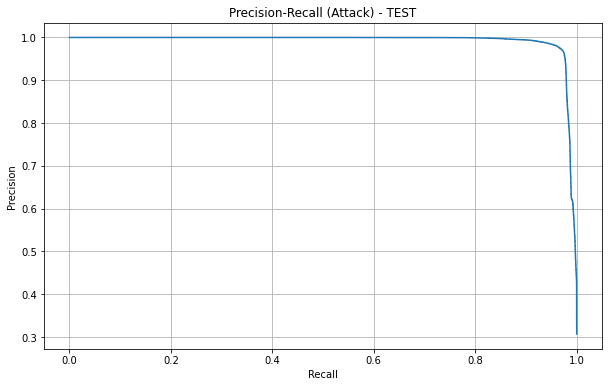

In [31]:
prec, rec, _ = precision_recall_curve(yt, pt)

plt.figure(figsize=(10, 6))
plt.plot(rec, prec)
plt.title("Precision-Recall (Attack) - TEST")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid(True)
plt.show()

In [36]:
import os, json
import numpy as np
import pandas as pd

os.makedirs("exports", exist_ok=True)

ts_test_flow = df["Timestamp"].iloc[i_val:].reset_index(drop=True)

ends = np.array(test_ds.starts) + WINDOW_SIZE - 1
ts_test_win = ts_test_flow.iloc[ends].reset_index(drop=True)

p_attack = pt.astype(float)      # pt = prob Attack
y_true = yt.astype(int)
y_pred = (p_attack >= 0.5).astype(int)

out = pd.DataFrame({
    "pipeline": "p3_pca_transformer",
    "timestamp": ts_test_win,
    "y_true": y_true,
    "y_pred": y_pred,
    "p_attack": p_attack,
    "window_start": np.array(test_ds.starts, dtype=int),
    "window_end": ends.astype(int),
    "window_size": int(WINDOW_SIZE),
    "stride": int(STRIDE),
})

out.to_parquet("exports/p3_test_preds.parquet", index=False)
print("Guardado:", "exports/p3_test_preds.parquet", "| shape:", out.shape)

meta = {
    "pipeline": "p3_pca_transformer",
    "task": "binary",
    "split": "temporal",
    "train_frac": 0.70,
    "val_frac": 0.15,
    "test_frac": 0.15,
    "pca_components": int(X_train_pca.shape[1]),
    "window_size": int(WINDOW_SIZE),
    "stride": int(STRIDE),
}
with open("exports/p3_meta.json", "w", encoding="utf-8") as f:
    json.dump(meta, f, indent=2, default=str)
print("Guardado:", "exports/p3_meta.json")


Guardado: exports/p3_test_preds.parquet | shape: (84913, 9)
Guardado: exports/p3_meta.json
